# 🛠️ Environment Setup

In [2]:
from google.colab import drive
drive.mount('/content/drive')

# Go to Where notebook lives
from datetime import datetime
from pathlib import Path

CACHE = Path("/content/data_local")  # Local cache to speed up training
PROJECT_DIR = Path("/content/drive/MyDrive/RSICD_PROJECT")

NOTEBOOK_DIR = PROJECT_DIR / "scripts/models"
OUTPUTS_ROOT = NOTEBOOK_DIR / "outputs"

%cd $NOTEBOOK_DIR
!ls


Mounted at /content/drive
/content/drive/MyDrive/RSICD_PROJECT/scripts/models
blip1_backup.ipynb  blip1.ipynb


# 📊  Data preprocessing

In [4]:
DATA_DIR = Path(PROJECT_DIR) / "data"

DATA_RAW_DIR = DATA_DIR / "raw"
!ls "{DATA_RAW_DIR}" # Check what's in raw image folder in Drive

DATA_PROCESSED_DIR = DATA_DIR / "processed"
!ls "{DATA_PROCESSED_DIR}" # List processed data files

import json
from collections import defaultdict

def check_caption_density(path):
    with open(path) as f:
        data = json.load(f)

    image_to_captions = defaultdict(list)
    for ann in data["annotations"]:
        image_to_captions[ann["image_id"]].append(ann["caption"])

    lengths = [len(c) for c in image_to_captions.values()]
    print(f"\n{path}")
    print(f"Images: {len(image_to_captions)}")
    print(f"Captions: {len(data['annotations'])}")
    print(f"Min: {min(lengths)}, Max: {max(lengths)}, Avg: {sum(lengths)/len(lengths):.2f}")

check_caption_density(DATA_PROCESSED_DIR / "captions_train2017.json")
check_caption_density(DATA_PROCESSED_DIR / "captions_val2017.json")
check_caption_density(DATA_PROCESSED_DIR / "captions_test2017.json")

dataset_rsicd.json  example.PNG  README.md   txtclasses_rsicd
delete		    images	 readme.txt
captions_test2017.json	captions_train2017.json  captions_val2017.json

/content/drive/MyDrive/RSICD_PROJECT/data/processed/captions_train2017.json
Images: 8736
Captions: 43680
Min: 5, Max: 5, Avg: 5.00

/content/drive/MyDrive/RSICD_PROJECT/data/processed/captions_val2017.json
Images: 1092
Captions: 5460
Min: 5, Max: 5, Avg: 5.00

/content/drive/MyDrive/RSICD_PROJECT/data/processed/captions_test2017.json
Images: 1093
Captions: 5465
Min: 5, Max: 5, Avg: 5.00


In [53]:
# Copy data to local cache (do this ONCE per Colab session)
!cp -r "{DATA_DIR}" "{CACHE}"

In [11]:
# Confirm copied structure
!ls "{CACHE}/data/processed"
!ls "{CACHE}/data/raw/images/" | wc -l  # Should show number of images (e.g., 10921)

if (CACHE / "data/processed/captions_train2017.json").exists():
    DATA_ROOT = Path(CACHE) / "data"
else:
    DATA_ROOT = Path(PROJECT_DIR) / "data"

GLOBAL_ARGS = {
    'train_json': str(DATA_ROOT / "processed/captions_train2017.json"),
    'val_json': str(DATA_ROOT / "processed/captions_val2017.json"),
    'test_json': str(DATA_ROOT / "processed/captions_test2017.json"),
    'image_dir': str(DATA_ROOT / "raw/images"),
    'model_name': 'Salesforce/blip-image-captioning-base',
}

captions_test2017.json	captions_train2017.json  captions_val2017.json
10921


# 📦 Library Imports

In [12]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Fri Aug  1 11:52:42 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   30C    P0             42W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [57]:
!pip install -q transformers torch torchvision pillow nltk matplotlib tqdm pycocoevalcap

# ==============================================================================
# 📦 Standard Library Imports
# ==============================================================================
import os
import gc
import torch
import random
import numpy as np
import warnings

# ==============================================================================
# 📦 Third-Party Imports
# ==============================================================================
import os
import json
import time
import math
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image
from collections import defaultdict

import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import BlipProcessor, BlipForConditionalGeneration
from torch.optim.lr_scheduler import ReduceLROnPlateau

from IPython.display import display, HTML, clear_output

# ==============================================================================
# ⚙️ Global Setup: Seeds, Warnings, Memory
# ==============================================================================
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

warnings.filterwarnings("ignore")
torch.cuda.empty_cache()
gc.collect()
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:128"

# Device config
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ⚙️ Training Configuration

#Training 1 - Barebone 5 Epoch

- lr: 5e-7
- Minimal Training Setup, Strip down to absolute minimum
- Add Gradient Monitoring
- Use Teacher Forcing Ratio

In [17]:
from pathlib import Path

# Output directory for this experiment
OUTPUT_DIR = PROJECT_DIR / "outputs/blip1/blip1_rsicd_original_lr5e7_v2"
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Base training config + experiment overrides
training_args = {
    **GLOBAL_ARGS,
    'output_dir': str(OUTPUT_DIR),

    # Option 1
    'batch_size': 6,
    'learning_rate': 5e-7,
    'weight_decay': 0.01,           # Added weight decay

    # Option 2
    # 'batch_size': 8,
    # 'learning_rate': 5e-5,        # 100x increase from 5e-7 or change to 3e-5

    'label_smoothing': 0.0,         # Disable label smoothing
    'warmup_steps': 0,              # Disable warmup
    'gradient_clip': 1.0,           # Explicit gradient clipping value

    'num_epochs': 5,
    'early_stopping_patience': 3,
    'resume': True,                 # Will resume if checkpoint is found
}

In [58]:
# ==============================================================================
# 📁 Output and Logging Setup
# ==============================================================================
import logging
# Writes to console and training_log.txt
log_file = OUTPUT_DIR / "training_log.txt"

# Clear any previous logging handlers
for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)

logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler(log_file),
        logging.StreamHandler()
    ]
)

def log_and_print(message):
    """Log to file and print to notebook"""
    logging.info(message)

# 🗂️ Define Dataset

In [59]:
class RSICDDataset(Dataset):
    def __init__(self, json_path, image_dir, processor, split='train'):
        self.image_dir = Path(image_dir)
        self.processor = processor
        self.split = split

        with open(json_path, 'r') as f:
            data = json.load(f)

        annotations = defaultdict(list)
        for ann in data['annotations']:
            annotations[ann['image_id']].append(ann['caption'])

        self.samples = []
        for img in data['images']:
            if img['id'] in annotations:
                img_path = self.image_dir / img['file_name']
                captions = annotations[img['id']]
                for caption in captions:
                    self.samples.append({
                        'image_path': img_path,
                        'caption': caption,
                        'image_id': img['id'],
                        'file_name': img['file_name'],
                        'all_captions': captions
                    })

        self.image_ids = [s['image_id'] for s in self.samples]
        self.id_to_filename = {s['image_id']: s['file_name'] for s in self.samples}

        log_and_print(f"Loaded {len(self.samples)} samples for {split}")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx]
        img_path = sample['image_path']
        try:
            image = Image.open(img_path).convert('RGB')
        except:
            return None

        encoding = self.processor(
            image,
            sample['caption'].lower(),
            padding="max_length",
            truncation=True,
            max_length=40,
            return_tensors="pt"
        )
        encoding = {k: v.squeeze() for k, v in encoding.items()}
        encoding['image_id'] = sample['image_id']
        encoding['file_name'] = sample['file_name']
        encoding['all_captions'] = sample['all_captions']
        return encoding

# 🚂 Train Model

In [60]:
# ==============================================================================
# 🔧 Sanity check: Test Pretrained Model First
# ==============================================================================

def test_pretrained_model(device):
    """Test if pretrained BLIP works before training"""
    log_and_print("\n🔍 Testing pretrained BLIP model...")

    model = BlipForConditionalGeneration.from_pretrained('Salesforce/blip-image-captioning-base')
    processor = BlipProcessor.from_pretrained('Salesforce/blip-image-captioning-base')
    model = model.to(device)
    model.eval()

    # Test on a dummy image
    dummy_image = torch.randn(1, 3, 384, 384).to(device)

    # Test generation
    with torch.no_grad():
        generated = model.generate(dummy_image, max_length=20)
        caption = processor.decode(generated[0], skip_special_tokens=True)
        log_and_print(f"Test caption (random image): {caption}")

        # Check if output is degenerate
        if len(caption) < 3 or all(c == caption[0] for c in caption):
            log_and_print("⚠️ WARNING: Model generating garbage on random input!")

    # Test with a real image if possible
    try:
        import requests
        url = "http://images.cocodataset.org/val2017/000000039769.jpg"
        image = Image.open(requests.get(url, stream=True).raw)
        inputs = processor(image, return_tensors="pt").to(device)

        with torch.no_grad():
            out = model.generate(**inputs, max_length=20)
            real_caption = processor.decode(out[0], skip_special_tokens=True)
            log_and_print(f"Test caption (real image): {real_caption}")

    except:
        log_and_print("Could not test with real image (no internet?)")

    # Verify vocabulary alignment
    model_vocab_size = model.config.text_config.vocab_size
    processor_vocab_size = len(processor.tokenizer)
    log_and_print(f"Model vocab size: {model_vocab_size}")
    log_and_print(f"Processor vocab size: {processor_vocab_size}")

    # Check special tokens
    log_and_print(f"Pad token ID: {processor.tokenizer.pad_token_id}")
    log_and_print(f"BOS token ID: {processor.tokenizer.bos_token_id}")
    log_and_print(f"EOS token ID: {processor.tokenizer.eos_token_id}")

    log_and_print("✅ Pretrained model test complete\n")
    return True

In [61]:
# ==============================================================================
# 🔧  Training with Gradient Monitoring - UPDATED with label smoothing
# ==============================================================================
from IPython.display import display
import matplotlib.pyplot as plt

def train_epoch_with_monitoring(model, dataloader, optimizer, scheduler, device, epoch, num_epochs, scaler, args):
    """UPDATED: Added label smoothing and warmup support"""
    model.train()
    total_loss = 0
    batch_count = 0

    progress_bar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}")
    for batch_idx, batch in enumerate(progress_bar):
        if batch is None:
            continue

        # Move batch to device
        pixel_values = batch['pixel_values'].to(device)
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)

        # Debug first batch
        if epoch == 0 and batch_idx == 0:
            log_and_print(f"\n📊 First batch debug:")
            log_and_print(f"Pixel values shape: {pixel_values.shape}")
            log_and_print(f"Input IDs shape: {input_ids.shape}")
            log_and_print(f"Batch size: {len(pixel_values)}")

        # Prepare labels
        labels = input_ids.clone()
        labels[labels == model.config.pad_token_id] = -100

        # Forward pass with mixed precision
        with torch.cuda.amp.autocast():
            outputs = model(
                pixel_values=pixel_values,
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels,
                return_dict=True
            )
            # ==================================================================
            # CHANGED: Apply label smoothing if configured
            if args['label_smoothing'] > 0:
                # Get logits and apply label smoothing
                logits = outputs.logits
                log_probs = F.log_softmax(logits, dim=-1)

                # Reshape for loss calculation
                batch_size, seq_len, vocab_size = logits.shape
                log_probs = log_probs.view(-1, vocab_size)
                labels_flat = labels.view(-1)

                # Calculate label smoothed loss
                smooth_loss = -log_probs.mean(dim=-1)

                # Standard cross entropy
                nll_loss = F.nll_loss(log_probs, labels_flat, ignore_index=-100, reduction='none')

                # Combine
                loss = (1 - args['label_smoothing']) * nll_loss + args['label_smoothing'] * smooth_loss
                loss = loss[labels_flat != -100].mean()  # Only average over non-padding tokens
            else:
                loss = outputs.loss
            # ==================================================================

        # Check for anomalies
        if torch.isnan(loss) or torch.isinf(loss):
            log_and_print(f"⚠️ WARNING: Invalid loss at batch {batch_idx}: {loss.item()}")
            continue

        # Scaled backward pass
        scaler.scale(loss).backward()

        # Unscale before gradient clipping
        scaler.unscale_(optimizer)

        # CHANGED: Use configured gradient clipping value
        grad_norm = float(torch.nn.utils.clip_grad_norm_(model.parameters(), args['gradient_clip']))

        if math.isnan(grad_norm):
            log_and_print("⚠️ CRITICAL: NaN gradients detected!")
            optimizer.zero_grad()
            scaler.update()
            continue

        # Scaled optimizer step
        scaler.step(optimizer)
        scaler.update()

        # CHANGED: Step scheduler if using warmup
        if hasattr(scheduler, 'step') and args.get('warmup_steps', 0) > 0:
            scheduler.step()

        optimizer.zero_grad()

        # Update metrics
        current_loss = loss.item()
        total_loss += current_loss
        batch_count += 1

        # Update progress bar with current learning rate
        current_lr = optimizer.param_groups[0]['lr']
        progress_bar.set_postfix({
            'loss': f'{current_loss:.4f}',
            'avg_loss': f'{total_loss / batch_count:.4f}',
            'grad_norm': f'{grad_norm:.2f}',
            'lr': f'{current_lr:.2e}'
        })

        # Sample generation for monitoring
        if epoch == 0 and batch_idx % 100 == 0 and batch_idx > 0:
            model.eval()
            with torch.no_grad():
                # Generate from first image in batch
                sample_out = model.generate(
                    pixel_values[:1],
                    max_length=20,
                    num_beams=1
                )
                sample_caption = dataloader.dataset.processor.decode(sample_out[0], skip_special_tokens=True)

                # Get metadata
                image_id = batch['image_ids'][0] if 'image_ids' in batch else 'N/A'
                file_name = batch['file_names'][0] if 'file_names' in batch else 'N/A'

                log_and_print(f"\n🧪 Sample Generation at Epoch {epoch+1} Step {batch_idx}")
                log_and_print(f"🖼️ Image ID: {image_id}")
                log_and_print(f"📝 File Name: {file_name}")
                log_and_print(f"🧠 Generated: {sample_caption}\n")

            model.train()

    return total_loss / max(batch_count, 1)

In [62]:
# ==============================================================================
# Simple validation
# ==============================================================================

def validate_simple(model, dataloader, device):
    """Validation with FP16 support"""
    model.eval()
    total_loss = 0
    batch_count = 0

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Validating"):
            if batch is None:
                continue

            pixel_values = batch['pixel_values'].to(device)
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)

            labels = input_ids.clone()
            labels[labels == model.config.pad_token_id] = -100

            # Use autocast for validation too
            with torch.cuda.amp.autocast():
                outputs = model(
                    pixel_values=pixel_values,
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    labels=labels,
                    return_dict=True
                )

            if not torch.isnan(outputs.loss):
                total_loss += outputs.loss.item()
                batch_count += 1

    return total_loss / max(batch_count, 1)

# ==============================================================================
# Conservative Generation
# ==============================================================================
def generate_captions_conservative(model, pixel_values):
    """Very conservative generation settings"""
    return model.generate(
        pixel_values,
        max_length=30,
        num_beams=3,
        temperature=1.0,
        repetition_penalty=1.2,
        no_repeat_ngram_size=3,
        early_stopping=True,
    )

# ==============================================================================
# Evaluation functions
# ==============================================================================
def evaluate_mini_simple(model, processor, dataloader, device, epoch, num_samples=50):
    """Simple evaluation with debugging + saving to file"""
    model.eval()
    successful_captions = []
    degenerate_count = 0

    with torch.no_grad():
        for i, batch in enumerate(dataloader):
            if batch is None:
                continue
            if len(successful_captions) >= num_samples:
                break

            pixel_values = batch['pixel_values'].to(device)

            # Generate for each image in batch
            generated_ids = generate_captions_conservative(model, pixel_values)

            # Decode all
            for j in range(len(generated_ids)):
                if len(successful_captions) >= num_samples:
                    break

                caption = processor.decode(generated_ids[j], skip_special_tokens=True)

                # Check if degenerate
                if len(caption) > 0 and not all(c == caption[0] for c in caption):
                    successful_captions.append(caption)
                else:
                    degenerate_count += 1
                    if degenerate_count <= 5:
                        log_and_print(f"Degenerate output: '{caption}'")

    log_and_print(f"Generated {len(successful_captions)} valid captions, {degenerate_count} degenerate")

    # Save valid captions to file
    output_path = OUTPUT_DIR / f"generated_captions_epoch{epoch+1}.json"
    with open(output_path, "w") as f:
        json.dump(successful_captions, f, indent=2)
    log_and_print(f"📝 Saved generated captions to {output_path}")

    return successful_captions


# ==============================================================================
# BLEU Score Evaluation
# ==============================================================================
def evaluate_mini_bleu(model, processor, dataloader, device, num_samples=50):
    """Evaluate BLEU-1 to BLEU-4 on small validation subset"""
    try:
        from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
    except ImportError:
        log_and_print("❌ NLTK not available, skipping BLEU evaluation")
        return {"bleu1": 0.0, "bleu2": 0.0, "bleu3": 0.0, "bleu4": 0.0}

    model.eval()
    predictions, references = [], []
    count = 0
    smoothing = SmoothingFunction().method1

    with torch.no_grad():
        for i, batch in enumerate(dataloader):
            if batch is None:
                continue
            if count >= num_samples:
                break

            pixel_values = batch['pixel_values'].to(device)

            # Generate captions
            generated_ids = generate_captions_conservative(model, pixel_values)

            # Process each generation in batch
            for j in range(len(generated_ids)):
                if count >= num_samples:
                    break

                pred = processor.decode(generated_ids[j], skip_special_tokens=True)

                # Get reference captions if available
                if 'all_captions' in batch and j < len(batch['all_captions']):
                    refs = batch['all_captions'][j]
                else:
                    continue

                # Check for valid prediction
                if pred and len(pred.strip()) > 0 and not all(c == pred[0] for c in pred):
                    predictions.append(pred.lower().split())
                    references.append([r.lower().split() for r in refs])
                    count += 1

    if not predictions:
        log_and_print("❌ No valid predictions for BLEU evaluation")
        return {"bleu1": 0.0, "bleu2": 0.0, "bleu3": 0.0, "bleu4": 0.0}

    scores = {"bleu1": [], "bleu2": [], "bleu3": [], "bleu4": []}

    try:
        for pred, refs in zip(predictions, references):
            scores["bleu1"].append(sentence_bleu(refs, pred, weights=(1, 0, 0, 0), smoothing_function=smoothing))
            scores["bleu2"].append(sentence_bleu(refs, pred, weights=(0.5, 0.5, 0, 0), smoothing_function=smoothing))
            scores["bleu3"].append(sentence_bleu(refs, pred, weights=(0.33, 0.33, 0.33, 0), smoothing_function=smoothing))
            scores["bleu4"].append(sentence_bleu(refs, pred, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smoothing))
    except Exception as e:
        log_and_print(f"❌ BLEU calculation failed: {e}")
        return {"bleu1": 0.0, "bleu2": 0.0, "bleu3": 0.0, "bleu4": 0.0}

    # Handle empty scores
    final_scores = {}
    for k, v in scores.items():
        if v:
            final_scores[k] = sum(v) / len(v)
        else:
            final_scores[k] = 0.0

    log_and_print(f"📊 BLEU evaluation completed on {len(predictions)} samples")
    return final_scores


In [63]:
# ==============================================================================
# Collate function
# ==============================================================================

def collate_fn(batch):
    """Custom collate function that stacks tensors properly"""
    # Filter out None entries
    batch = [item for item in batch if item is not None]
    if len(batch) == 0:
        return None

    # Stack all tensor fields
    collated = {}
    keys_to_stack = ['pixel_values', 'input_ids', 'attention_mask']

    for key in keys_to_stack:
        if key in batch[0]:
            collated[key] = torch.stack([item[key] for item in batch])

    # Keep metadata as lists
    if 'image_id' in batch[0]:
        collated['image_ids'] = [item['image_id'] for item in batch]
    if 'file_name' in batch[0]:
        collated['file_names'] = [item['file_name'] for item in batch]
    if 'all_captions' in batch[0]:
        collated['all_captions'] = [item['all_captions'] for item in batch]

    return collated

In [64]:
# ==============================================================================
# Main function - UPDATED with new hyperparameters
# ==============================================================================
def main(args):
    """Main training function - UPDATED for augmented dataset"""
    # Initialize GradScaler for FP16
    scaler = torch.cuda.amp.GradScaler()

    # ==========================================================================
    # Setup
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    log_and_print(f"Using device: {device}")

    # Log configuration
    log_and_print("\n📋 Training Configuration:")
    log_and_print(f"  Dataset: Augmented RSICD (3x original)")
    log_and_print(f"  Learning rate: {args['learning_rate']} (100x increase)")
    log_and_print(f"  Batch size: {args['batch_size']}")
    log_and_print(f"  Epochs: {args['num_epochs']}")
    log_and_print(f"  Weight decay: {args['weight_decay']}")
    log_and_print(f"  Label smoothing: {args['label_smoothing']}")
    log_and_print(f"  Warmup steps: {args['warmup_steps']}")
    log_and_print(f"  Gradient clipping: {args['gradient_clip']}")

    # STEP 1: Test pretrained model first
    if not test_pretrained_model(device):
        raise ValueError("Pretrained model test failed!")
    # ==========================================================================
    # Load model and processor
    log_and_print(f"\nLoading model: {args['model_name']}")
    processor = BlipProcessor.from_pretrained(args['model_name'])
    model = BlipForConditionalGeneration.from_pretrained(args['model_name'])
    if model.config.pad_token_id is None:
        model.config.pad_token_id = processor.tokenizer.pad_token_id
    assert model.config.pad_token_id is not None
    log_and_print(f"✅ pad_token_id = {model.config.pad_token_id}")

    # Basic model setup
    model = model.to(device)

    # Train full model (encoder + decoder)
    log_and_print("🔓 Training FULL model (encoder + decoder)")

    # ==========================================================================
    # Prepare resume logic BEFORE optimizer
    resume_path = OUTPUT_DIR / "checkpoints/last_checkpoint.pth"
    start_epoch = 0
    history = {
        'train_loss': [],
        'val_loss': [],
        'bleu1': [],
        'bleu2': [],
        'bleu3': [],
        'bleu4': [],
        'epochs': []
    }
    patience_counter = 0
    optimizer_state = None
    scheduler_state = None

    if resume_path.exists() and args.get('resume', False):
        log_and_print(f"🔁 Found checkpoint at {resume_path}, resuming...")
        checkpoint = torch.load(resume_path, map_location=device)
        model.load_state_dict(checkpoint['model_state'])
        optimizer_state = checkpoint['optimizer_state']
        scheduler_state = checkpoint['scheduler_state']
        history = checkpoint['history']
        start_epoch = checkpoint['epoch']
        patience_counter = checkpoint['patience_counter']
    else:
        if resume_path.exists():
            log_and_print(f"⚠️ Found old checkpoint but starting fresh (different optimizer config)")
            # Optionally rename old checkpoint to avoid confusion
            import shutil
            backup_path = OUTPUT_DIR / "checkpoints/old_last_checkpoint.pth"
            if resume_path.exists():
                shutil.move(str(resume_path), str(backup_path))
                log_and_print(f"📁 Moved old checkpoint to: {backup_path}")
    # ==========================================================================
    # Dataset setup
    log_and_print("\n📂 Loading augmented dataset...")
    train_dataset = RSICDDataset(args['train_json'], args['image_dir'], processor, 'train')
    val_dataset = RSICDDataset(args['val_json'], args['image_dir'], processor, 'val')

    # Create dataloaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=args['batch_size'],
        shuffle=True,
        collate_fn=collate_fn,
        num_workers=2,  # CHANGED: Parallel data loading
        pin_memory=True,  # CHANGED: Faster GPU transfer
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=args['batch_size'],
        shuffle=False,
        collate_fn=collate_fn,
        num_workers=2,  # CHANGED: Parallel data loading
        pin_memory=True,  # CHANGED: Faster GPU transfer
    )

    # ==========================================================================

    # CHANGED: Optimizer with weight decay
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=args['learning_rate'],
        eps=1e-8,
        weight_decay=args['weight_decay']  # Added weight decay
    )

    # CHANGED: Calculate total training steps for warmup
    total_training_steps = len(train_loader) * args['num_epochs']

    # CHANGED: Create warmup scheduler if configured
    if args.get('warmup_steps', 0) > 0:
        from transformers import get_linear_schedule_with_warmup
        warmup_scheduler = get_linear_schedule_with_warmup(
            optimizer,
            num_warmup_steps=args['warmup_steps'],
            num_training_steps=total_training_steps
        )
        log_and_print(f"✅ Warmup scheduler created with {args['warmup_steps']} warmup steps")
    else:
        warmup_scheduler = None

    # Keep ReduceLROnPlateau for validation-based scheduling
    plateau_scheduler = ReduceLROnPlateau(
        optimizer,
        mode='min',
        factor=0.1,
        patience=3,
        verbose=True
    )

    # Restore optimizer/scheduler if resuming
    if optimizer_state:
        optimizer.load_state_dict(optimizer_state)
        if warmup_scheduler and 'warmup_scheduler_state' in checkpoint:
            warmup_scheduler.load_state_dict(checkpoint['warmup_scheduler_state'])
        plateau_scheduler.load_state_dict(scheduler_state)
        log_and_print(f"🔄 Optimizer and scheduler state restored")

    # ==========================================================================
    # Training loop
    log_and_print("\n🚀 Starting training with augmented dataset...")
    log_and_print("="*60)

    best_val_loss = float('inf')
    best_bleu4 = 0.0
    for epoch in range(start_epoch, args['num_epochs']):
        epoch_start = time.time()

        # Train with monitoring - pass warmup scheduler if using warmup
        train_loss = train_epoch_with_monitoring(
            model, train_loader, optimizer,
            warmup_scheduler if warmup_scheduler else plateau_scheduler,
            device, epoch, args['num_epochs'], scaler, args
        )

        # Validate
        val_loss = validate_simple(model, val_loader, device)

        # Step plateau scheduler with val_loss (only if not using warmup or after warmup is done)
        if not warmup_scheduler or (epoch * len(train_loader) + len(train_loader)) > args['warmup_steps']:
            plateau_scheduler.step(val_loss)

        # Generation and BLEU
        sample_captions = evaluate_mini_simple(model, processor, val_loader, device, epoch, num_samples=10)
        log_and_print(f"\n📝 Sample generated captions:")
        for i, caption in enumerate(sample_captions[:3]):
            log_and_print(f"  Sample {i+1}: {caption}")

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['epochs'].append(epoch + 1)

        # ======================================================================
        log_and_print(f"\n📊 Computing BLEU scores for epoch {epoch+1}...")
        try:
            # Metric for Accuracy Curve
            bleu_scores = evaluate_mini_bleu(model, processor, val_loader, device, num_samples=50)
            history['bleu1'].append(bleu_scores['bleu1'])
            history['bleu2'].append(bleu_scores['bleu2'])
            history['bleu3'].append(bleu_scores['bleu3'])
            history['bleu4'].append(bleu_scores['bleu4'])

            log_and_print(f"\n📈 Epoch {epoch+1} Results:")
            log_and_print(f"  Train Loss: {train_loss:.4f}")
            log_and_print(f"  Val Loss: {val_loss:.4f}")
            log_and_print(f"  BLEU-1: {bleu_scores['bleu1']:.4f}")
            log_and_print(f"  BLEU-2: {bleu_scores['bleu2']:.4f}")
            log_and_print(f"  BLEU-3: {bleu_scores['bleu3']:.4f}")
            log_and_print(f"  BLEU-4: {bleu_scores['bleu4']:.4f}")
            log_and_print(f"  Time: {time.time() - epoch_start:.1f}s")

            current_bleu4 = bleu_scores['bleu4']
        except Exception as e:
            log_and_print(f"❌ BLEU evaluation failed: {e}")
            history['bleu1'].append(0.0)
            history['bleu2'].append(0.0)
            history['bleu3'].append(0.0)
            history['bleu4'].append(0.0)
            current_bleu4 = 0.0

        # ======================================================================
        # Save best model based on BLEU-4 score
        if current_bleu4 > best_bleu4:
            best_bleu4 = current_bleu4
            best_val_loss = val_loss
            patience_counter = 0

            model_path = OUTPUT_DIR / "best_model"
            model_path.mkdir(exist_ok=True)
            model.save_pretrained(model_path)
            processor.save_pretrained(model_path)
            log_and_print(f"✅ Saved best model (BLEU-4: {best_bleu4:.4f})")
        else:
            patience_counter += 1
            log_and_print(f"⏳ EarlyStopping counter: {patience_counter} / {args['early_stopping_patience']}")
            if patience_counter > args['early_stopping_patience']:
                log_and_print("⏹️ Early stopping triggered due to no BLEU-4 improvement")
                break

        # ======================================================================
        # Save history
        history_file = OUTPUT_DIR / "training_history.json"
        with open(history_file, 'w') as f:
            json.dump(history, f, indent=2)

        # Save checkpoint
        checkpoint_dir = OUTPUT_DIR / "checkpoints"
        checkpoint_dir.mkdir(exist_ok=True)
        checkpoint = {
            'model_state': model.state_dict(),
            'optimizer_state': optimizer.state_dict(),
            'scheduler_state': plateau_scheduler.state_dict(),
            'history': history,
            'epoch': epoch + 1,
            'patience_counter': patience_counter,
            'best_bleu4': best_bleu4
        }
        if warmup_scheduler:
            checkpoint['warmup_scheduler_state'] = warmup_scheduler.state_dict()

        torch.save(checkpoint, checkpoint_dir / "last_checkpoint.pth")
        log_and_print(f"💾 Checkpoint saved: epoch {epoch+1}")

    log_and_print(f"\n🎉 Training completed!")
    log_and_print(f"Best BLEU-4: {best_bleu4:.4f}")
    log_and_print(f"Best validation loss: {best_val_loss:.4f}")

    return model, processor, history

In [ ]:
# ==============================================================================
# Run the training
# ==============================================================================

# if __name__ == "__main__":
try:
    # Verify augmented dataset exists
    if not Path(training_args['train_json']).exists():
        log_and_print(f"❌ Augmented training JSON not found at {training_args['train_json']}")
        log_and_print("Please run the augmentation script first!")
    elif not Path(training_args['image_dir']).exists():
        log_and_print(f"❌ Augmented image directory not found at {training_args['image_dir']}")
        log_and_print("Please run the augmentation script first!")
    else:
        log_and_print("\n✅ Augmented dataset found!")
        log_and_print(f"Expected: 131,040 caption-image pairs (3x original)")

        model, processor, history = main(training_args)
except Exception as e:
    log_and_print(f"\n❌ Training failed with error: {e}")
    raise

## On console to keep collab alive

```js
function ClickConnect(){
    console.log("Clicked on connect button");
    document.querySelector("colab-connect-button").click()
}

const myInterval = setInterval(ClickConnect, 60000);

//To clear
clearInterval(myInterval);
```


## 📈 Plot Curves

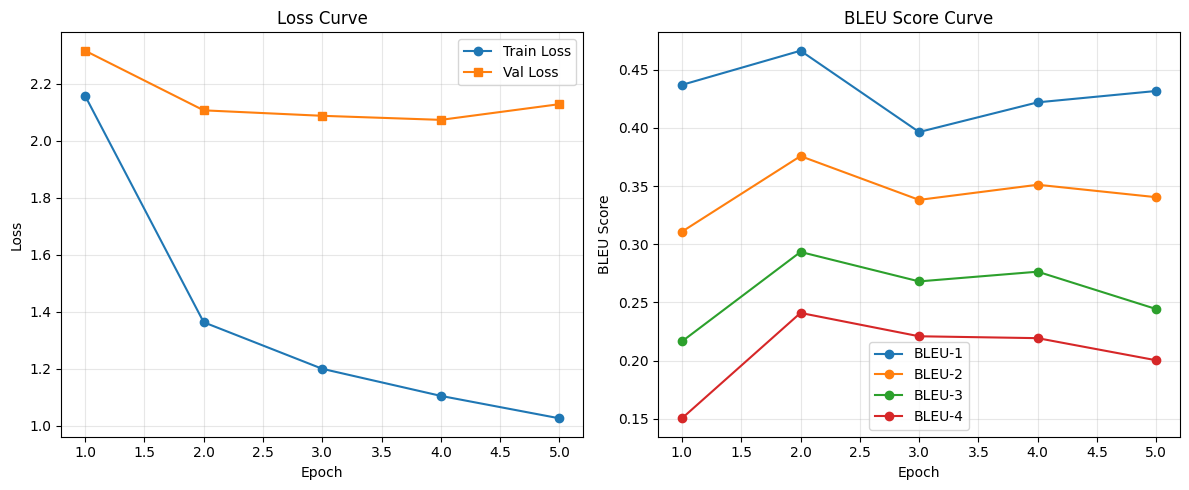

2025-08-01 13:32:05,970 - INFO - 📊 Training curves saved to: /content/drive/MyDrive/RSICD_PROJECT/outputs/blip1/blip1_rsicd_original_lr5e7_v2/training_curves.png


In [18]:
# ==============================================================================
# Loss + BLEU Score Evaluation
# ==============================================================================
def plot_training_curves(history):
    """Create training curves with error handling"""
    try:
        import matplotlib.pyplot as plt
        epochs = history['epochs']

        if not epochs:
            log_and_print("❌ No epoch data to plot")
            return

        plt.figure(figsize=(12, 5))

        # Loss Curve
        plt.subplot(1, 2, 1)
        if history['train_loss'] and history['val_loss']:
            plt.plot(epochs, history['train_loss'], label="Train Loss", marker='o')
            plt.plot(epochs, history['val_loss'], label="Val Loss", marker='s')
            plt.xlabel("Epoch")
            plt.ylabel("Loss")
            plt.title("Loss Curve")
            plt.legend()
            plt.grid(True, alpha=0.3)

        # BLEU Curve
        plt.subplot(1, 2, 2)
        if any(history[k] for k in ['bleu1', 'bleu2', 'bleu3', 'bleu4']):
            for bleu_key, label in [('bleu1', 'BLEU-1'), ('bleu2', 'BLEU-2'),
                                   ('bleu3', 'BLEU-3'), ('bleu4', 'BLEU-4')]:
                if history[bleu_key]:
                    plt.plot(epochs, history[bleu_key], label=label, marker='o')
            plt.xlabel("Epoch")
            plt.ylabel("BLEU Score")
            plt.title("BLEU Score Curve")
            plt.legend()
            plt.grid(True, alpha=0.3)

        plt.tight_layout()
        plot_path = OUTPUT_DIR / "training_curves.png"
        plt.savefig(plot_path, dpi=300, bbox_inches='tight')
        plt.show()
        log_and_print(f"📊 Training curves saved to: {plot_path}")

    except Exception as e:
        log_and_print(f"❌ Failed to create training curves: {e}")

# Plot Curves
plot_training_curves(history)


## 📈 Evaluate Model on Test Dataset

In [ ]:
#!/usr/bin/env python3

!pip install -q pycocotools git+https://github.com/salaniz/pycocoevalcap

from transformers import BlipProcessor, BlipForConditionalGeneration
from PIL import Image
import torch, json, os
from pathlib import Path
from tqdm import tqdm
from pycocotools.coco import COCO
from pycocoevalcap.eval import COCOEvalCap

# === Paths ===
MODEL_DIR = OUTPUT_DIR / "best_model"

# === Load model & processor ===
processor = BlipProcessor.from_pretrained(MODEL_DIR)
model = BlipForConditionalGeneration.from_pretrained(MODEL_DIR).to(device).eval()

TEST_JSON = PROJECT_DIR / 'data/processed/captions_test2017.json'
IMAGE_DIR = PROJECT_DIR / 'data/raw/images'

# NEW FILENAMES FOR BEAM SEARCH
OUT_COCO = OUTPUT_DIR / "generated_captions_formatted_beam5.json"
OUT_DEBUG = OUTPUT_DIR / "generated_captions_debug_beam5.json"

In [21]:
# === Load test metadata ===
with open(TEST_JSON) as f:
    test_data = json.load(f)

id_to_file = {img["id"]: img["file_name"] for img in test_data["images"]}

annotations = {}
for ann in test_data["annotations"]:
    annotations.setdefault(ann["image_id"], []).append(ann["caption"])

debug_results = []
coco_results = []

# === Generate captions with beam search ===
for image_id, file_name in tqdm(id_to_file.items(), desc="Generating captions with beam search"):
    img = Image.open(os.path.join(IMAGE_DIR, file_name)).convert("RGB")
    inputs = processor(images=img, return_tensors="pt").to("cuda")

    with torch.no_grad():
        out = model.generate(
            **inputs,
            max_new_tokens=30,
            num_beams=5,
            early_stopping=True,
            no_repeat_ngram_size=3
        )
        caption = processor.decode(out[0], skip_special_tokens=True)

    # Append to both outputs
    debug_results.append({
        "image_id": image_id,
        "file_name": file_name,
        "generated": caption,
        "ground_truth": annotations.get(image_id, [])
    })

    coco_results.append({
        "image_id": image_id,
        "caption": caption
    })

# === Save outputs ===
with open(OUT_DEBUG, "w") as f:
    json.dump(debug_results, f, indent=2)

with open(OUT_COCO, "w") as f:
    json.dump(coco_results, f, indent=2)

print("✅ Done! Saved:")
print(f"  - COCO format: {OUT_COCO}")
print(f"  - Full debug : {OUT_DEBUG}")

# === Evaluate ===
coco = COCO(TEST_JSON)
coco_res = coco.loadRes(str(OUT_COCO))

coco_eval = COCOEvalCap(coco, coco_res)
coco_eval.evaluate()

# === Display nicely formatted metrics ===
metrics = coco_eval.eval
print("\n📊 Evaluation Metrics:")
print("|   Model  | BLEU-1 | BLEU-2 | BLEU-3 | BLEU-4 | METEOR | ROUGE_L | CIDEr  | SPICE  |")
print("|----------|--------|--------|--------|--------|--------|---------|--------|--------|")
print(f"|  BLIP-1  | {metrics['Bleu_1']:.4f} | {metrics['Bleu_2']:.4f} | {metrics['Bleu_3']:.4f} | {metrics['Bleu_4']:.4f} | {metrics['METEOR']:.4f} |  {metrics['ROUGE_L']:.4f} | {metrics['CIDEr']:.4f} | {metrics['SPICE']:.4f} |")

  Preparing metadata (setup.py) ... done


Generating captions with beam search: 100%|██████████| 1093/1093 [05:59<00:00,  3.04it/s]


✅ Done! Saved:
  - COCO format: /content/drive/MyDrive/RSICD_PROJECT/outputs/blip1/blip1_rsicd_original_lr5e7_v2/generated_captions_formatted_beam5.json
  - Full debug : /content/drive/MyDrive/RSICD_PROJECT/outputs/blip1/blip1_rsicd_original_lr5e7_v2/generated_captions_debug_beam5.json
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
tokenization...
setting up scorers...
Progress: 384.5M / 384.5M (100.0%)
Extracting stanford-corenlp-3.6.0 ...
Done.
computing Bleu score...
{'testlen': 11779, 'reflen': 11829, 'guess': [11779, 10686, 9593, 8500], 'correct': [8294, 4239, 2253, 1288]}
ratio: 0.9957731000083696
Bleu_1: 0.701
Bleu_2: 0.526
Bleu_3: 0.402
Bleu_4: 0.314
computing METEOR score...
METEOR: 0.275
computing Rouge score...
ROUGE_L: 0.491
computing CIDEr score...
CIDEr: 0.693
computing SPICE score...
SPICE: 0.268

📊 Evaluation Metrics:
|   Model  | BLEU-1 | BLEU-2 | BLEU-3

📊 Evaluation Metrics:

|   Model  | BLEU-1 | BLEU-2 | BLEU-3 | BLEU-4 | METEOR | ROUGE_L | CIDEr  | SPICE  |
|----------|--------|--------|--------|--------|--------|---------|--------|--------|
|  BLIP-1  | 0.7012 | 0.5263 | 0.4016 | 0.3144 | 0.2751 |  0.4908 | 0.6930 | 0.2679 |

## 🖼️ Caption Comparison on Specific Images

In [45]:
# ==============================================================================
# 📊 Evaluate Caption on a Single RSICD Image
# ==============================================================================
from pycocotools.coco import COCO
from pycocoevalcap.eval import COCOEvalCap
from IPython.display import display, HTML
from PIL import Image
import matplotlib.pyplot as plt
import torch
import re
import json
import os
import contextlib
import io
from difflib import SequenceMatcher
from pathlib import Path

# === Global path to prediction JSON (adjust if needed) ===
MODEL_NAME = "Blip1"
test_dataset = RSICDDataset(TEST_JSON, IMAGE_DIR, processor, split='test')
gt_json = TEST_JSON
pred_json = OUT_COCO

def show_specific_example_with_metric(image_filename, dataset, model, processor):
    model.eval()
    device = next(model.parameters()).device

    # Find dataset index
    index = None
    for i, img_id in enumerate(dataset.image_ids):
        if dataset.id_to_filename[img_id] == image_filename:
            index = i
            break
    if index is None:
        print(f"Image {image_filename} not found in dataset.")
        return

    # Load input
    # print(dataset[index])
    # pixel_values, _, reference_captions = dataset[index]
    sample = dataset[index]
    pixel_values = sample['pixel_values']
    reference_captions = sample['all_captions']

    image_path = os.path.join(dataset.image_dir, image_filename)
    original_image = Image.open(image_path).convert("RGB")
    pixel_values_batch = pixel_values.unsqueeze(0).to(device)

    with torch.no_grad():
        # output_ids = model.generate(
        #     pixel_values_batch,
        #     max_length=30,
        #     num_beams=1
        #     )
        output_ids = model.generate(
          pixel_values_batch,
          max_length=30,
          num_beams=5,
          do_sample=False,
          early_stopping=True
        )
        # output_ids = model.generate(
        #     pixel_values_batch,
        #     max_length=30,
        #     do_sample=True,        # Enables random sampling instead of greedy or beam search
        #     top_k=50,              # Sample only from the top 50 likely tokens
        #     top_p=0.95,            # Nucleus sampling: sample from tokens covering 95% cumulative probability, can adjust
        #     temperature=1.0,       # Higher → more randomness; lower → more conservative
        #     num_return_sequences=3 # Optional Set to >1 to get multiple caption variations
        # )

        generated_caption = processor.decode(output_ids[0], skip_special_tokens=True)

    # Tokenize
    gen_tokens = re.findall(r"\b\w+\b", generated_caption.lower())
    ref_tokens_all = []
    for caption in reference_captions:
        ref_tokens_all += re.findall(r"\b\w+\b", caption.lower())
    ref_word_set = set(ref_tokens_all)

    # BLEU-n highlight
    def get_ngrams(tokens, n):
        return set(tuple(tokens[i:i+n]) for i in range(len(tokens)-n+1))

    def bleu_n_highlight(gen_tokens, ref_tokens, n, color):
        gen_ngrams = get_ngrams(gen_tokens, n)
        ref_ngrams = get_ngrams(ref_tokens, n)
        matches = gen_ngrams & ref_ngrams
        result = []
        i = 0
        while i < len(gen_tokens):
            ngram = tuple(gen_tokens[i:i+n])
            if len(ngram) == n and ngram in matches:
                result.append(f"<span style='color:{color}'>{' '.join(ngram)}</span>")
                i += n
            else:
                result.append(gen_tokens[i])
                i += 1
        return ' '.join(result)

    bleu1_html = ' '.join([f"<span style='color:blue'>{w}</span>" if w in ref_word_set else w for w in gen_tokens])
    bleu2_html = bleu_n_highlight(gen_tokens, ref_tokens_all, 2, "blue")
    bleu3_html = bleu_n_highlight(gen_tokens, ref_tokens_all, 3, "blue")
    bleu4_html = bleu_n_highlight(gen_tokens, ref_tokens_all, 4, "blue")

    # ROUGE-L
    def lcs(a, b):
        sm = SequenceMatcher(None, a, b)
        return [a[i] for i, j, n in sm.get_matching_blocks() if n > 0 for i in range(i, i + n)]

    best_lcs = []
    best_caption_idx = -1
    for idx, caption in enumerate(reference_captions):
        ref = re.findall(r"\b\w+\b", caption.lower())
        lcs_seq = lcs(gen_tokens, ref)
        if len(lcs_seq) > len(best_lcs):
            best_lcs = lcs_seq
            best_caption_idx = idx

    best_lcs_set = set(best_lcs)
    rouge_gen_html = ' '.join([
        f"<span style='color:green'><b>{w}</b></span>" if w in best_lcs_set else w
        for w in gen_tokens
    ])

    # ===============================
    # Display Section
    # ===============================
    plt.figure(figsize=(5, 5))
    plt.imshow(original_image)
    plt.title("Generated Caption", fontsize=10)
    plt.axis('off')
    plt.show()

    print(f"\n🖼️ Image: {image_filename}\n")
    print("📄 Ground Truth Captions:\n")
    gt_lines = []
    for j, ref in enumerate(reference_captions):
        if j == best_caption_idx:
            ref_words = ref.split()
            highlighted = ' '.join(
                f"<span style='color:green'>{w}</span>" if w.lower() in best_lcs_set else w
                for w in ref_words
            )
            line = f"<b>{j+1}.</b> {highlighted}"
        else:
            line = f"<b>{j+1}.</b> {ref}"
        gt_lines.append(f"<div style='margin-left: 20px'>{line}</div>")
    display(HTML("".join(gt_lines)))

    print("\n🔮 Generated Caption (highlighted):")
    for label, html_caption in [
        ("BLEU1", bleu1_html),
        ("BLEU2", bleu2_html),
        ("BLEU3", bleu3_html),
        ("BLEU4", bleu4_html),
        ("ROUGE-L", rouge_gen_html),
    ]:
        display(HTML(f"<div style='margin-left: 20px'><b>{label}:</b> {html_caption}</div>"))

    # # ===============================
    # # Evaluation Metrics Section
    # # ===============================
    # with open(gt_json, 'r') as f: gt_data = json.load(f)
    # with open(pred_json, 'r') as f: pred_data = json.load(f)

    # filename_to_id = {img["file_name"]: img["id"] for img in gt_data["images"]}
    # if image_filename not in filename_to_id:
    #     print(f"\n⚠️ Warning: Image not found in COCO GT file.\n")
    #     return
    # img_id = filename_to_id[image_filename]

    # single_gt = {
    #     "info": {},  # Required dummy field
    #     "licenses": [],  # Required dummy field
    #     "type": "captions",  # Required by COCO API
    #     "images": [{"id": img_id, "file_name": image_filename}],
    #     "annotations": [ann for ann in gt_data["annotations"] if ann["image_id"] == img_id]
    # }

    # single_pred = [entry for entry in pred_data if entry["image_id"] == img_id]

    # with contextlib.redirect_stdout(io.StringIO()):
    #     coco = COCO()
    #     coco.dataset = single_gt
    #     coco.createIndex()
    #     coco_res = coco.loadRes(single_pred)
    #     coco_eval = COCOEvalCap(coco, coco_res)
    #     coco_eval.evaluate()

    # m = coco_eval.eval
    # print("\n📊 Evaluation Metrics:")
    # print("| Model   | BLEU-1 | BLEU-2 | BLEU-3 | BLEU-4 | METEOR | ROUGE_L | SPICE |")
    # print("|---------|--------|--------|--------|--------|--------|---------|-------|")
    # print(f"| {MODEL_NAME:<7} |  {m['Bleu_1']:.2f}  |  {m['Bleu_2']:.2f}  |  {m['Bleu_3']:.2f}  |  {m['Bleu_4']:.2f}  |"
    #       f"  {m['METEOR']:.2f}  |  {m['ROUGE_L']:.2f}   |  {m['SPICE']:.2f} |")
    # print("-" * 80)

2025-08-01 14:34:31,757 - INFO - Loaded 5465 samples for test


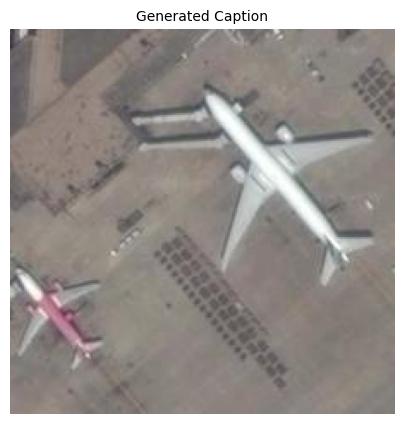


🖼️ Image: 00493.jpg

📄 Ground Truth Captions:




🔮 Generated Caption (highlighted):


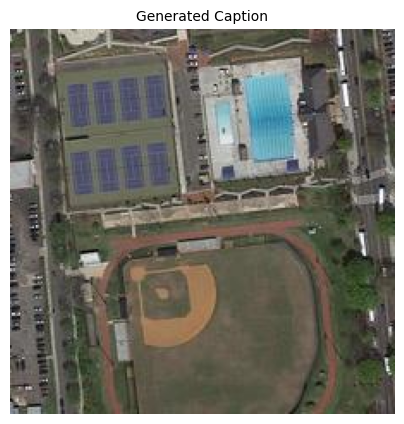


🖼️ Image: 00834.jpg

📄 Ground Truth Captions:




🔮 Generated Caption (highlighted):


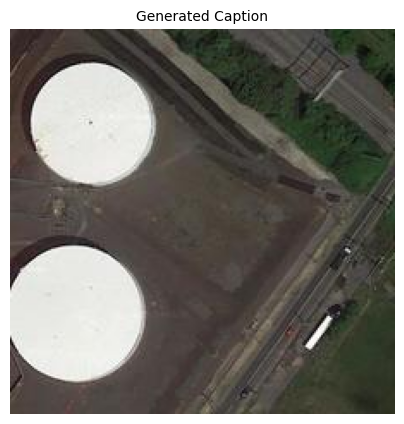


🖼️ Image: 00867.jpg

📄 Ground Truth Captions:




🔮 Generated Caption (highlighted):


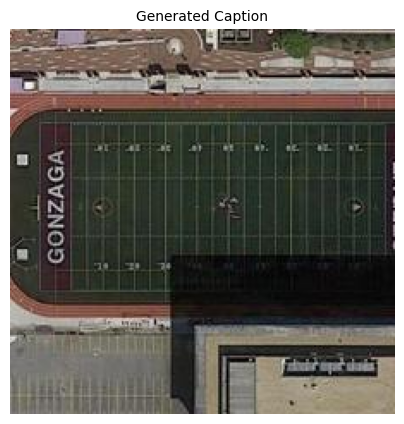


🖼️ Image: 00846.jpg

📄 Ground Truth Captions:




🔮 Generated Caption (highlighted):


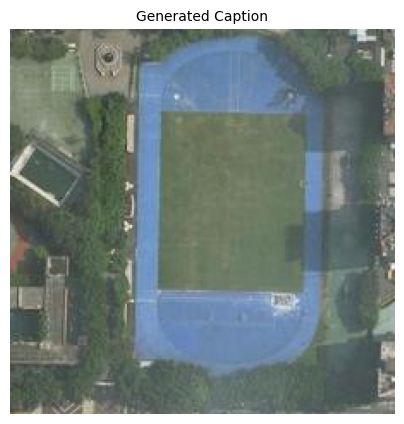


🖼️ Image: 00424.jpg

📄 Ground Truth Captions:




🔮 Generated Caption (highlighted):


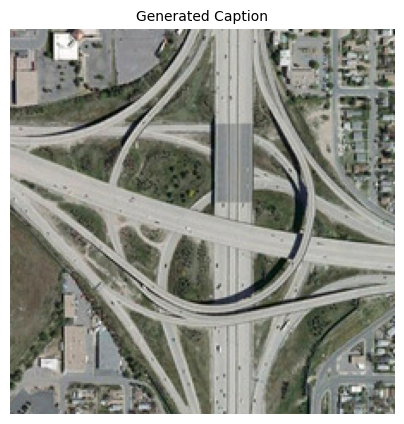


🖼️ Image: viaduct_328.jpg

📄 Ground Truth Captions:




🔮 Generated Caption (highlighted):


In [48]:
# 5 images to compare with the different models

show_specific_example_with_metric("00493.jpg", test_dataset, model, processor)
show_specific_example_with_metric("00834.jpg", test_dataset, model, processor)
show_specific_example_with_metric("00867.jpg", test_dataset, model, processor)
show_specific_example_with_metric("00846.jpg", test_dataset, model, processor)
show_specific_example_with_metric("00424.jpg", test_dataset, model, processor)
show_specific_example_with_metric("viaduct_328.jpg", test_dataset, model, processor)

# show_specific_example_with_metric("00695.jpg", test_dataset, model, processor)
# show_specific_example_with_metric("00407.jpg", test_dataset, model, processor)
# show_specific_example_with_metric("00373.jpg", test_dataset, model, processor)
# show_specific_example_with_metric("00348.jpg", test_dataset, model, processor)
# show_specific_example_with_metric("viaduct_329.jpg", test_dataset, model, processor)
# show_specific_example_with_metric("viaduct_351.jpg", test_dataset, model, processor)

#Training 2 - 2 Extra Variants

In [50]:
#!/usr/bin/env python3

"""
RSICD Dataset Augmentation Script for Google Colab
Generates 2 augmented variants per training image with de-duplicated captions
(8,736 images x 5 captions = 43,680 caption-image pairs) * 3 = 131040 image caption pairs
"""

import os
import json
import shutil
from pathlib import Path
from PIL import Image
import torch
from torchvision import transforms
from tqdm import tqdm
import random
import numpy as np

# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

# ==============================================================================
# Configuration
# ==============================================================================

# Original data paths
original_data_args = {
    'train_json': PROJECT_DIR / 'data/processed/captions_train2017.json',
    'image_dir': PROJECT_DIR / 'data/raw/images',
}

# Augmented data paths
augmented_data_args = {
    'train_json': PROJECT_DIR / 'data/augmentation_v1/captions_train_augmented.json',
    'image_dir': PROJECT_DIR / 'data/augmentation_v1/images',
}
# ==============================================================================
# Define Augmentation Variants
# ==============================================================================

from torchvision import transforms
from torchvision.transforms import functional as TF
from torchvision.transforms import InterpolationMode
import torch
import random
from PIL import ImageEnhance

# ==============================================================================
from torchvision.transforms.functional import (
    adjust_brightness, adjust_contrast,
    adjust_saturation, adjust_hue
)

class FixedColorTransform:
    def __init__(self, brightness=1.0, contrast=1.0, saturation=1.0, hue=0.0):
        self.brightness = brightness
        self.contrast = contrast
        self.saturation = saturation
        self.hue = hue
# 20% brighter (brightness=1.2)
    def __call__(self, img):

        img = adjust_brightness(img, self.brightness)
        img = adjust_contrast(img, self.contrast)
        img = adjust_saturation(img, self.saturation)
        img = adjust_hue(img, self.hue)
        return img

class AdjustSharpnessTransform:
    def __init__(self, sharpness_factor=2.0):
        self.factor = sharpness_factor  # >1.0 sharpens, <1.0 blurs

    def __call__(self, img):
        return ImageEnhance.Sharpness(img).enhance(self.factor)

class RandomSharpness:
    """Applies random sharpening in a mild, safe range."""
    def __init__(self, min_factor=1.0, max_factor=2.0):
        self.min = min_factor
        self.max = max_factor

    def __call__(self, img):
        factor = random.uniform(self.min, self.max)
        return ImageEnhance.Sharpness(img).enhance(factor)

class AdjustLevelsTransform:
    """Photoshop-style levels adjustment (black/white point clipping)."""
    def __init__(self, black_level=40/255, white_level=210/255):
        self.black = black_level
        self.white = white_level

    def __call__(self, img):
        img_tensor = TF.to_tensor(img)
        img_tensor = (img_tensor - self.black) / (self.white - self.black)
        img_tensor = torch.clamp(img_tensor, 0.0, 1.0)
        return TF.to_pil_image(img_tensor)

# ==============================================================================
# class Safe45Rotate:
#     """Rotate 45° safely with expand=True and padded background fill."""
#     def __call__(self, img):
#         fill_color = tuple([int(c * 255) for c in TF.to_tensor(img).mean(dim=(1, 2))])
#         return TF.rotate(img, angle=45, interpolation=TF.InterpolationMode.BILINEAR, expand=True, fill=fill_color)

class AxialRotateTransform:
    """Rotates 90 or 270 degrees randomly (true axial rotation)."""
    def __call__(self, img):
        angle = random.choice([90, 270])
        return TF.rotate(img, angle, interpolation=InterpolationMode.BILINEAR)

# ==============================================================================

#option 1
variant1_transform = transforms.Compose([
    AxialRotateTransform(),
    FixedColorTransform(brightness=1.2, contrast=1.0, saturation=1.5, hue=0.0),
    # AdjustSharpnessTransform(sharpness_factor=3.5),
    RandomSharpness(min_factor=1.0, max_factor=2.0),
    AdjustLevelsTransform(black_level=0/255, white_level=240/255),
    transforms.Resize((384, 384)),
    transforms.ToTensor()
])

variant2_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=1.0),
    transforms.RandomResizedCrop(384, scale=(0.95, 1.0), ratio=(0.95, 1.05)),
    FixedColorTransform(brightness=1.0, contrast=1.2, saturation=1.1, hue=0.05),
    AdjustSharpnessTransform(sharpness_factor=3.5),
    AdjustLevelsTransform(black_level=10/255, white_level=210/255),
    transforms.Resize(384),
    transforms.ToTensor()
])

# ==============================================================================
# Helper Functions
# ==============================================================================

def create_directories():
    """Create necessary directories for augmented dataset"""
    augmented_dir = Path(augmented_data_args['image_dir'])
    augmented_dir.mkdir(parents=True, exist_ok=True)
    print(f"✓ Created directory: {augmented_dir}")

    # Create parent directory for JSON
    json_dir = Path(augmented_data_args['train_json']).parent
    json_dir.mkdir(parents=True, exist_ok=True)
    print(f"✓ Created directory: {json_dir}")


# ==============================================================================
# Caption Redordering based on TFIDF
# ==============================================================================

from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

def deduplicate_and_pad_captions(captions, target_count=5):
    """
    De-duplicate captions, score them, place the most descriptive first,
    and pad to target count if needed.
    """

    # Remove duplicates while preserving order
    seen = set()
    unique_captions = []
    for caption in captions:
        if caption not in seen:
            seen.add(caption)
            unique_captions.append(caption)

    # Score unique captions using a basic TF-IDF vectorizer
    if len(unique_captions) > 1:
        tfidf = TfidfVectorizer()
        tfidf_matrix = tfidf.fit_transform(unique_captions)
        rarity_scores = tfidf_matrix.sum(axis=1).A1  # Sum of TF-IDF scores per sentence
        best_idx = int(np.argmax(rarity_scores))
        best_caption = unique_captions[best_idx]
        # Move best caption to the front
        unique_captions.pop(best_idx)
        unique_captions = [best_caption] + unique_captions

    # Pad if necessary (cyclic repeat)
    while len(unique_captions) < target_count:
        unique_captions.append(unique_captions[len(unique_captions) % len(unique_captions)])

    return unique_captions[:target_count]

# ==============================================================================
# Create Original + 2 Variants
# ==============================================================================

def process_and_save_image(image_path, output_path, transform):
    """Apply transformation and save image"""
    try:
        # Open image
        img = Image.open(image_path).convert('RGB')

        # Apply transformation
        img_transformed = transform(img)

        # Convert back to PIL if tensor
        if isinstance(img_transformed, torch.Tensor):
            # Convert tensor to PIL
            img_transformed = transforms.ToPILImage()(img_transformed)

        # Save image
        img_transformed.save(output_path, quality=95)
        return True
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return False

def generate_augmented_dataset():
    """Main function to generate augmented dataset"""

    print("="*60)
    print("RSICD DATASET AUGMENTATION")
    print("="*60)

    # Create directories
    create_directories()

    # Load original training JSON
    print(f"\nLoading original training data from: {original_data_args['train_json']}")
    with open(original_data_args['train_json'], 'r') as f:
        original_data = json.load(f)

    print(f"✓ Loaded {len(original_data['images'])} images")
    print(f"✓ Loaded {len(original_data['annotations'])} annotations")

    # Initialize new augmented data structure
    augmented_data = {
        "images": [],
        "annotations": [],
        "info": {
            "description": "RSICD Augmented Training Set (Original + 2 Variants)",
            "version": "1.0",
            "year": 2025,
            "contributor": "RSICD Dataset - Augmented",
            "date_created": str(Path(original_data_args['train_json']).stat().st_mtime)
        },
        "licenses": original_data.get("licenses", [])
    }

    # Create mapping of image_id to captions
    image_id_to_captions = {}
    for ann in original_data['annotations']:
        if ann['image_id'] not in image_id_to_captions:
            image_id_to_captions[ann['image_id']] = []
        image_id_to_captions[ann['image_id']].append(ann['caption'])

    # Process counters
    total_images = len(original_data['images'])
    processed_images = 0
    new_annotation_id = 0

    print(f"\nProcessing {total_images} images (generating 3 versions each)...")
    print("This will create {total_images * 3} = {total_images * 3} total images")

    # Process each image
    for img_data in tqdm(original_data['images'], desc="Processing images"):
        image_id = img_data['id']
        original_filename = img_data['file_name']
        original_path = Path(original_data_args['image_dir']) / original_filename

        if not original_path.exists():
            print(f"Warning: Image not found: {original_path}")
            continue

        # Get captions for this image
        captions = image_id_to_captions.get(image_id, [])
        if not captions:
            print(f"Warning: No captions found for image {image_id}")
            continue

        # Process original captions
        original_captions = captions

        # Process augmented captions (de-duplicate and pad)
        augmented_captions = deduplicate_and_pad_captions(captions)

        # === 1. Copy Original Image ===
        original_output_path = Path(augmented_data_args['image_dir']) / original_filename
        try:
            # shutil.copy2(original_path, original_output_path)
            img = Image.open(original_path).convert("RGB")
            img_resized = transforms.Resize((384, 384))(img)
            img_resized.save(original_output_path, quality=95)

            # Add original image entry
            augmented_data['images'].append({
                "id": image_id,
                "file_name": original_filename,
                "width": 384,
                "height": 384,
                "license": img_data.get('license', 1),
                "date_captured": img_data.get('date_captured', "")
            })

            # Add original annotations (unchanged)
            for caption in original_captions:
                augmented_data['annotations'].append({
                    "id": new_annotation_id,
                    "image_id": image_id,
                    "caption": caption
                })
                new_annotation_id += 1

        except Exception as e:
            print(f"Error copying original image {original_filename}: {e}")
            continue

        # === 2. Generate Variant 1 ===
        variant1_filename = original_filename.rsplit('.', 1)[0] + '_v1.' + original_filename.rsplit('.', 1)[1]
        variant1_output_path = Path(augmented_data_args['image_dir']) / variant1_filename
        variant1_image_id = int(str(image_id) + "001")

        if process_and_save_image(original_path, variant1_output_path, variant1_transform):
            # Add variant 1 image entry
            augmented_data['images'].append({
                "id": variant1_image_id,
                "file_name": variant1_filename,
                "width": 384,
                "height": 384,
                "license": img_data.get('license', 1),
                "date_captured": img_data.get('date_captured', "")
            })

            # Add variant 1 annotations (de-duplicated)
            for caption in augmented_captions:
                augmented_data['annotations'].append({
                    "id": new_annotation_id,
                    "image_id": variant1_image_id,
                    "caption": caption
                })
                new_annotation_id += 1

        # === 3. Generate Variant 2 ===
        variant2_filename = original_filename.rsplit('.', 1)[0] + '_v2.' + original_filename.rsplit('.', 1)[1]
        variant2_output_path = Path(augmented_data_args['image_dir']) / variant2_filename
        variant2_image_id = int(str(image_id) + "002")

        if process_and_save_image(original_path, variant2_output_path, variant2_transform):
            # Add variant 2 image entry
            augmented_data['images'].append({
                "id": variant2_image_id,
                "file_name": variant2_filename,
                "width": 384,
                "height": 384,
                "license": img_data.get('license', 1),
                "date_captured": img_data.get('date_captured', "")
            })

            # Add variant 2 annotations (de-duplicated)
            for caption in augmented_captions:
                augmented_data['annotations'].append({
                    "id": new_annotation_id,
                    "image_id": variant2_image_id,
                    "caption": caption
                })
                new_annotation_id += 1

        processed_images += 1

    # Save augmented JSON
    print(f"\nSaving augmented dataset JSON to: {augmented_data_args['train_json']}")
    with open(augmented_data_args['train_json'], 'w') as f:
        json.dump(augmented_data, f, indent=2)

    # Print summary
    print("\n" + "="*60)
    print("AUGMENTATION COMPLETE!")
    print("="*60)
    print(f"✓ Total images created: {len(augmented_data['images'])}")
    print(f"  - Original images: {processed_images}")
    print(f"  - Variant 1 images: ~{processed_images}")
    print(f"  - Variant 2 images: ~{processed_images}")
    print(f"✓ Total annotations: {len(augmented_data['annotations'])}")
    print(f"✓ Expected image-caption pairs: {len(augmented_data['images']) * 5}")
    print(f"✓ Images saved to: {augmented_data_args['image_dir']}")
    print(f"✓ JSON saved to: {augmented_data_args['train_json']}")

    # Verify counts
    unique_images = len(set(img['file_name'] for img in augmented_data['images']))
    print(f"\n✓ Unique image files: {unique_images}")

    # Show sample of de-duplicated captions
    print("\n📝 Sample caption de-duplication:")
    sample_img_id = original_data['images'][0]['id'] if original_data['images'] else None
    if sample_img_id and sample_img_id in image_id_to_captions:
        original_caps = image_id_to_captions[sample_img_id]
        dedup_caps = deduplicate_and_pad_captions(original_caps)
        print(f"Original ({len(original_caps)}): {original_caps}")
        print(f"De-duplicated & padded (5): {dedup_caps}")

# ==============================================================================
# Main Execution
# ==============================================================================

# if __name__ == "__main__":

# Check if original data exists
if not Path(original_data_args['train_json']).exists():
    print(f"❌ Error: Original training JSON not found at {original_data_args['train_json']}")
    print("Please ensure your data is in the correct location.")
elif not Path(original_data_args['image_dir']).exists():
    print(f"❌ Error: Original image directory not found at {original_data_args['image_dir']}")
    print("Please ensure your images are in the correct location.")
else:
    # Run augmentation
    generate_augmented_dataset()

    print("\n🎉 Augmentation complete! You can now use the augmented dataset for training.")
    print("\nTo use in your training script, update your paths to:")
    print(f"  train_json: '{augmented_data_args['train_json']}'")
    print(f"  image_dir: '{augmented_data_args['image_dir']}'")

RSICD DATASET AUGMENTATION
✓ Created directory: /content/drive/MyDrive/RSICD_PROJECT/data/augmentation_v1/images
✓ Created directory: /content/drive/MyDrive/RSICD_PROJECT/data/augmentation_v1

Loading original training data from: /content/drive/MyDrive/RSICD_PROJECT/data/processed/captions_train2017.json
✓ Loaded 8736 images
✓ Loaded 43680 annotations

Processing 8736 images (generating 3 versions each)...
This will create {total_images * 3} = {total_images * 3} total images


Processing images: 100%|██████████| 8736/8736 [10:49<00:00, 13.46it/s]



Saving augmented dataset JSON to: /content/drive/MyDrive/RSICD_PROJECT/data/augmentation_v1/captions_train_augmented.json

AUGMENTATION COMPLETE!
✓ Total images created: 26208
  - Original images: 8736
  - Variant 1 images: ~8736
  - Variant 2 images: ~8736
✓ Total annotations: 131040
✓ Expected image-caption pairs: 131040
✓ Images saved to: /content/drive/MyDrive/RSICD_PROJECT/data/augmentation_v1/images
✓ JSON saved to: /content/drive/MyDrive/RSICD_PROJECT/data/augmentation_v1/captions_train_augmented.json

✓ Unique image files: 26208

📝 Sample caption de-duplication:

🎉 Augmentation complete! You can now use the augmented dataset for training.

To use in your training script, update your paths to:
  train_json: '/content/drive/MyDrive/RSICD_PROJECT/data/augmentation_v1/captions_train_augmented.json'
  image_dir: '/content/drive/MyDrive/RSICD_PROJECT/data/augmentation_v1/images'


In [52]:
!ls /content/drive/MyDrive/RSICD_PROJECT/data/augmentation_v1/images | wc -l

26208


In [54]:
!ls /content/data_local/data/augmentation_v1/images | wc -l

26208


## Train same model on 131,040 images

In [55]:
# Output directory for this experiment
OUTPUT_DIR = PROJECT_DIR / "outputs/blip1/blip1_rsicd_original_lr5e7_131kimages_v3"
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Set this training to cache specifically
DATA_ROOT = Path(CACHE) / "data"

# Base training config + experiment overrides
training_args = {
    'train_json': str(DATA_ROOT / "augmentation_v1/captions_train_augmented.json"),
    'val_json': str(DATA_ROOT / "augmentation_v1/captions_val2017.json"),
    'test_json': str(DATA_ROOT / "augmentation_v1/captions_test2017.json"),
    'image_dir': str(DATA_ROOT / "augmentation_v1/images"),
    'model_name': 'Salesforce/blip-image-captioning-base',

    'output_dir': str(OUTPUT_DIR),

    # Option 1
    'batch_size': 6,
    'learning_rate': 5e-7,
    'weight_decay': 0.01,           # Added weight decay

    # Option 2
    # 'batch_size': 8,
    # 'learning_rate': 5e-5,        # 100x increase from 5e-7 or change to 3e-5

    'label_smoothing': 0.0,         # Disable label smoothing
    'warmup_steps': 0,              # Disable warmup
    'gradient_clip': 1.0,           # Explicit gradient clipping value

    'num_epochs': 5,
    'early_stopping_patience': 3,
    'resume': True,                 # Will resume if checkpoint is found
}

In [65]:
# ==============================================================================
# Run the training 2
# ==============================================================================

# if __name__ == "__main__":
try:
    # Verify augmented dataset exists
    if not Path(training_args['train_json']).exists():
        log_and_print(f"❌ Augmented training JSON not found at {training_args['train_json']}")
        log_and_print("Please run the augmentation script first!")
    elif not Path(training_args['image_dir']).exists():
        log_and_print(f"❌ Augmented image directory not found at {training_args['image_dir']}")
        log_and_print("Please run the augmentation script first!")
    else:
        log_and_print("\n✅ Augmented dataset found!")
        log_and_print(f"Expected: 131,040 caption-image pairs (3x original)")

        model, processor, history = main(training_args)
except Exception as e:
    log_and_print(f"\n❌ Training failed with error: {e}")
    raise

2025-08-01 15:27:27,628 - INFO - 
✅ Augmented dataset found!
2025-08-01 15:27:27,630 - INFO - Expected: 131,040 caption-image pairs (3x original)
2025-08-01 15:27:27,631 - INFO - Using device: cuda
2025-08-01 15:27:27,632 - INFO - 
📋 Training Configuration:
2025-08-01 15:27:27,632 - INFO -   Dataset: Augmented RSICD (3x original)
2025-08-01 15:27:27,633 - INFO -   Learning rate: 5e-07 (100x increase)
2025-08-01 15:27:27,633 - INFO -   Batch size: 6
2025-08-01 15:27:27,634 - INFO -   Epochs: 5
2025-08-01 15:27:27,634 - INFO -   Weight decay: 0.01
2025-08-01 15:27:27,635 - INFO -   Label smoothing: 0.0
2025-08-01 15:27:27,635 - INFO -   Warmup steps: 0
2025-08-01 15:27:27,636 - INFO -   Gradient clipping: 1.0
2025-08-01 15:27:27,636 - INFO - 
🔍 Testing pretrained BLIP model...
2025-08-01 15:27:31,810 - INFO - Test caption (random image): live camera from whitefaces mountain
2025-08-01 15:27:33,071 - INFO - Test caption (real image): two cats sleeping on a couch
2025-08-01 15:27:33,080 - 

KeyboardInterrupt: 

In [ ]:
#!/usr/bin/env python3

!pip install -q pycocotools git+https://github.com/salaniz/pycocoevalcap

from transformers import BlipProcessor, BlipForConditionalGeneration
from PIL import Image
import torch, json, os
from pathlib import Path
from tqdm import tqdm
from pycocotools.coco import COCO
from pycocoevalcap.eval import COCOEvalCap

# === Paths ===
MODEL_DIR = OUTPUT_DIR / "best_model"

# === Load model & processor ===
processor = BlipProcessor.from_pretrained(MODEL_DIR)
model = BlipForConditionalGeneration.from_pretrained(MODEL_DIR).to(device).eval()

TEST_JSON = PROJECT_DIR / 'data/processed/captions_test2017.json'
IMAGE_DIR = PROJECT_DIR / 'data/raw/images'

# NEW FILENAMES FOR BEAM SEARCH
OUT_COCO = OUTPUT_DIR / "generated_captions_formatted_beam5.json"
OUT_DEBUG = OUTPUT_DIR / "generated_captions_debug_beam5.json"

In [ ]:
# === Load test metadata ===
with open(TEST_JSON) as f:
    test_data = json.load(f)

id_to_file = {img["id"]: img["file_name"] for img in test_data["images"]}

annotations = {}
for ann in test_data["annotations"]:
    annotations.setdefault(ann["image_id"], []).append(ann["caption"])

debug_results = []
coco_results = []

# === Generate captions with beam search ===
for image_id, file_name in tqdm(id_to_file.items(), desc="Generating captions with beam search"):
    img = Image.open(os.path.join(IMAGE_DIR, file_name)).convert("RGB")
    inputs = processor(images=img, return_tensors="pt").to("cuda")

    with torch.no_grad():
        out = model.generate(
            **inputs,
            max_new_tokens=30,
            num_beams=5,
            early_stopping=True,
            no_repeat_ngram_size=3
        )
        caption = processor.decode(out[0], skip_special_tokens=True)

    # Append to both outputs
    debug_results.append({
        "image_id": image_id,
        "file_name": file_name,
        "generated": caption,
        "ground_truth": annotations.get(image_id, [])
    })

    coco_results.append({
        "image_id": image_id,
        "caption": caption
    })

# === Save outputs ===
with open(OUT_DEBUG, "w") as f:
    json.dump(debug_results, f, indent=2)

with open(OUT_COCO, "w") as f:
    json.dump(coco_results, f, indent=2)

print("✅ Done! Saved:")
print(f"  - COCO format: {OUT_COCO}")
print(f"  - Full debug : {OUT_DEBUG}")

# === Evaluate ===
coco = COCO(TEST_JSON)
coco_res = coco.loadRes(str(OUT_COCO))

coco_eval = COCOEvalCap(coco, coco_res)
coco_eval.evaluate()

# === Display nicely formatted metrics ===
metrics = coco_eval.eval
print("\n📊 Evaluation Metrics:")
print("|   Model  | BLEU-1 | BLEU-2 | BLEU-3 | BLEU-4 | METEOR | ROUGE_L | CIDEr  | SPICE  |")
print("|----------|--------|--------|--------|--------|--------|---------|--------|--------|")
print(f"|  BLIP-1  | {metrics['Bleu_1']:.4f} | {metrics['Bleu_2']:.4f} | {metrics['Bleu_3']:.4f} | {metrics['Bleu_4']:.4f} | {metrics['METEOR']:.4f} |  {metrics['ROUGE_L']:.4f} | {metrics['CIDEr']:.4f} | {metrics['SPICE']:.4f} |")